## Задание: (10 баллов)

Напишите класс, который реализует автоматическую трансформацию числовых колонок произвольного датафрейма в распределения,
    похожие на нормальные, после чего нормализует (см. семинар по предобработке). Класс должен автоматически для каждой колонки обучающей выборки (метод `fit`) определять, какая именно трансформация ей требуется, чтобы "превратиться в нормальную". Далее, в методе `transform` класс производит все необходимые трансформации + нормализацию для произвольной выборки. Ваш класс в рамках этого задания должен уметь работать со следующими распределениями:
- похожее на нормальное (только нормализация)
- мультимодальное (только нормализация)
- скошенное влево (обычно и сильно)
- скошенное вправо (обычно и сильно)
- равномерное
- "категориальное" (см. аргумент `cat_thr`)

Старайтесь подбирать трансформации из элементарных функций. Вы можете спрашивать LLM, как отличить одно распределение от другого. Вам пригодятся различные статистические показатели/тесты, в которые вы еще не проходили, но такова жизнь. Вы также можете попросить LLM написать вам этот класс, однако не ждите, что он будет работать хорошо с первого раза, придется дебажить каждый конкретный случай. Для написания кода рекомендую Qwen-Coder.

В файле `distributions.csv` лежат данные каждого типа, чтобы проверить себя. При сдаче работы выведите в левом столбике оригинальные данные (обычная и лог шкалы), а в правом -- после трансформации + нормализации (с флагом `use_quantile_transformer=False`), аналогично тому, как мы делали на семинаре. Без визуализации вы получите 0 баллов. Задание будет оцениваться субъективно на похожесть на нормальное распределение. За излишнее использование QuantileTransformer буду штрафовать. Пишите читаемый и аккуратный код. Удачи!

Шаблон с указанием необходимых параметров на вход (свои добавлять можно):

In [1]:
class FeatureTransformer:
    def __init__(self, scaler='StandardScaler', use_quantile_transformer=False, cat_thr=10, *args, **kwargs):
        '''
        scaler: str in ('StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler') or None
            -- вариант нормализации данных после трансформаций. None -- без нормализации.

        use_quantile_transformer: Если True, то в случаях, когда мы затрудняемся определить подходящую трансформацию из элементарных функций,
            используем sklearn.preprocessing.QuantileTransformer. Если False, то для таких колонок не используем трансформацию.

        cat_thr: если в колонке количество уникальных значений < cat_thr,
            мы ее считаем за категориальную и не трансформируем (нормализацию делаем)
        '''
        pass


    def fit(self, X, *args, **kwargs):
        '''
        "Обучаем" наш трансформатор -- собираем все необходимые данные на обучающей выборке, напр. mean, std для StandardScaler,
            а также "записываем", какую трансформацию нужно применить к каждой колонке
        '''
        pass
        return self


    def transform(self, X, *args, **kwargs):
        '''
        Применяем "записанные" трансформации + нормализацию на все необходимые колонки

        returns:
            X_transformed -- датафрейм размерности X, где все числовые колонки трансформированы (если надо) (+ нормализованы)
        '''
        pass
        return X_transformed


    def fit_transform(self, X, **fit_kwargs, **transform_kwargs):
        return self.fit(X, **fit_kwargs).transform(X, **transform_kwargs)

SyntaxError: arguments cannot follow var-keyword argument (1988060214.py, line 36)

In [3]:
import numpy as np
import scipy
from scipy.special import expit
from scipy.special import logsumexp
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer    
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import sys
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
sys.path.append('/home/boris/projects/aimasters/1sem/ML1/utils')
from utils import get_split, train_linear_model, get_df_info_mine, get_df_info, plot_density

In [4]:
df = pd.read_csv("distributions.csv")

In [ ]:
class normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_thr=10, skew_threshold=0.5, multimodal_threshold=0.1, use_quantile_transformer=False):
        """
        Автоматическая трансформация числовых колонок в нормальные распределения.
        
        Parameters:
        -----------
        cat_thr : int, default=10
            Порог для определения категориальных признаков
        skew_threshold : float, default=0.5
            Порог для определения скошенности
        multimodal_threshold : float, default=0.1
            Порог для определения мультимодальности
        use_quantile_transformer : bool, default=False
            Использовать ли QuantileTransformer как универсальное решение
        """
        self.cat_thr = cat_thr
        self.skew_threshold = skew_threshold
        self.multimodal_threshold = multimodal_threshold
        self.use_quantile_transformer = use_quantile_transformer
        self.transformers_ = {}
        self.scalers_ = {}
        self.distribution_types_ = {}
        
    def _detect_distribution_type(self, series):
        """Определяет тип распределения колонки"""
        # Удаляем NaN значения
        data = series.dropna()
        if len(data) < 10:
            return 'unknown'
            
        # Проверка на категориальное распределение
        unique_ratio = len(data.unique()) / len(data)
        if unique_ratio < 0.1 or len(data.unique()) <= self.cat_thr:
            return 'categorical'
            
        # Вычисляем скошенность
        skewness = stats.skew(data)
        

            
        # Проверка на равномерное распределение с помощью теста Колмогорова-Смирнова
        try:
            _, p_uniform = stats.kstest(data, 'uniform', 
                                      args=(np.min(data), np.max(data) - np.min(data)))
            if p_uniform > 0.05:
                return 'uniform'
        except:
            pass

        # Проверка на мультимодальность с помощью теста Хартлигана
        try:
            _, p_value = stats.mode(data)
            dip_stat = stats.dip(data)[0]
            # Простой тест на мультимодальность - проверяем несколько пиков в гистограмме
            hist, bins = np.histogram(data, bins='auto')
            peaks = np.where(hist > np.max(hist) * 0.7)[0]
            if len(peaks) > 1:
                return 'multimodal'
        except:
            pass
        # Определение типа по скошенности
        abs_skew = abs(skewness)
        if abs_skew < self.skew_threshold:
            return 'normal_like'
        elif skewness > self.skew_threshold:
            if skewness > 2.0:
                return 'strong_right_skewed'
            else:
                return 'right_skewed'
        elif skewness < -self.skew_threshold:
            if skewness < -2.0:
                return 'strong_left_skewed'
            else:
                return 'left_skewed'
        else:
            return 'unknown'
    
    def fit(self, X, y=None):
        """
        Обучение трансформатора на данных.
        
        Parameters:
        -----------
        X : DataFrame
            Входные данные для обучения
        y : None
            Не используется, для совместимости с sklearn
        """
        X = X.copy()
        
        for col in X.select_dtypes(include=[np.number]).columns:
            distribution_type = self._detect_distribution_type(X[col])
            self.distribution_types_[col] = distribution_type
            
            if self.use_quantile_transformer:
                # Используем QuantileTransformer как универсальное решение
                transformer = QuantileTransformer(output_distribution='normal', random_state=42)
                scaler = StandardScaler()
            else:
                # Подбираем трансформацию в зависимости от типа распределения
                transformer, scaler = self._get_transformer_for_type(distribution_type, X[col])
            
            # Обучаем трансформатор
            col_data = X[col].dropna().values.reshape(-1, 1)
            if len(col_data) > 0:
                transformer.fit(col_data)
                scaler.fit(transformer.transform(col_data))
                
            self.transformers_[col] = transformer
            self.scalers_[col] = scaler
            
        return self
    
    def _get_transformer_for_type(self, dist_type, series):
        """Возвращает подходящий трансформатор для типа распределения"""
        data = series.dropna().values.reshape(-1, 1)
        
        if dist_type == 'normal_like':
            # Только нормализация
            return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            
        elif dist_type == 'multimodal':
            # Только нормализация
            return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            
        elif dist_type == 'left_skewed':
            # Для лево-скошенных данных используем квадрат или экспоненту
            return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            
        elif dist_type == 'strong_left_skewed':
            # Для сильно лево-скошенных данных используем более сильные трансформации
            return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            
        elif dist_type == 'right_skewed':
            # Для право-скошенных данных используем логарифм
            try:
                # Проверяем, можно ли применить логарифм
                if np.min(data) > 0:
                    return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
                else:
                    # Если есть отрицательные значения, используем Yeo-Johnson
                    return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            except:
                return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
                
        elif dist_type == 'strong_right_skewed':
            # Для сильно право-скошенных данных используем более сильные трансформации
            try:
                if np.min(data) > 0:
                    return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
                else:
                    return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            except:
                return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
                
        elif dist_type == 'uniform':
            # Для равномерного распределения используем синусную трансформацию
            return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            
        elif dist_type == 'categorical':
            # Для категориальных данных используем стандартизацию
            return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
            
        else:
            # По умолчанию используем Yeo-Johnson
            return PowerTransformer(method='yeo-johnson', standardize=False), StandardScaler()
    
    def transform(self, X):
        """
        Применяет обученные трансформации к данным.
        
        Parameters:
        -----------
        X : DataFrame
            Входные данные для трансформации
            
        Returns:
        --------
        DataFrame
            Трансформированные данные
        """
        X_transformed = X.copy()
        
        for col in self.transformers_:
            if col in X.columns:
                col_data = X[col].values.reshape(-1, 1)
                mask = ~pd.isna(X[col])
                
                if np.sum(mask) > 0:
                    # Применяем трансформацию и нормализацию
                    transformed_data = self.transformers_[col].transform(col_data[mask])
                    normalized_data = self.scalers_[col].transform(transformed_data)
                    
                    # Заполняем результат
                    result_col = np.full(len(X[col]), np.nan)
                    result_col[mask] = normalized_data.flatten()
                    X_transformed[col] = result_col
                    
        return X_transformed
    
    def fit_transform(self, X, y=None):
        """Обучение и трансформация за один шаг"""
        return self.fit(X, y).transform(X)
    
    def plot_comparison(self, X_original, X_transformed, cols=None, figsize=(15, 10)):
        """
        Визуальное сравнение оригинальных и трансформированных распределений.
        
        Parameters:
        -----------
        X_original : DataFrame
            Оригинальные данные
        X_transformed : DataFrame
            Трансформированные данные
        cols : list, optional
            Список колонок для визуализации (по умолчанию все числовые)
        figsize : tuple, default=(15, 10)
            Размер фигуры
        """
        if cols is None:
            cols = X_original.select_dtypes(include=[np.number]).columns
            
        n_cols = len(cols)
        n_rows = 3  # Оригинал, лог-шкала, трансформированный
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        for i, col in enumerate(cols):
            # Оригинальное распределение
            ax1 = axes[0, i] if n_cols > 1 else axes[0]
            if col in X_original.columns:
                data = X_original[col].dropna()
                if len(data) > 0:
                    sns.histplot(data, ax=ax1, kde=True)
                    ax1.set_title(f'{col}\nОригинал ({self.distribution_types_[col]})')
                    ax1.set_ylabel('Частота')
            
            # Оригинал в лог-шкале (если применимо)
            ax2 = axes[1, i] if n_cols > 1 else axes[1]
            if col in X_original.columns:
                data = X_original[col].dropna()
                if len(data) > 0 and np.min(data) > 0:
                    try:
                        log_data = np.log(data)
                        sns.histplot(log_data, ax=ax2, kde=True)
                        ax2.set_title(f'{col}\nЛог-шкала')
                        ax2.set_ylabel('Частота')
                    except:
                        ax2.set_title(f'{col}\nЛог-шкала (не применимо)')
                else:
                    ax2.set_title(f'{col}\nЛог-шкала (не применимо)')
            
            # Трансформированное распределение
            ax3 = axes[2, i] if n_cols > 1 else axes[2]
            if col in X_transformed.columns:
                data = X_transformed[col].dropna()
                if len(data) > 0:
                    sns.histplot(data, ax=ax3, kde=True)
                    ax3.set_title(f'{col}\nТрансформированный')
                    ax3.set_ylabel('Частота')
                    ax3.set_xlabel('Значение')
        
        plt.tight_layout()
        plt.show()

Сравнение распределений до и после трансформации:


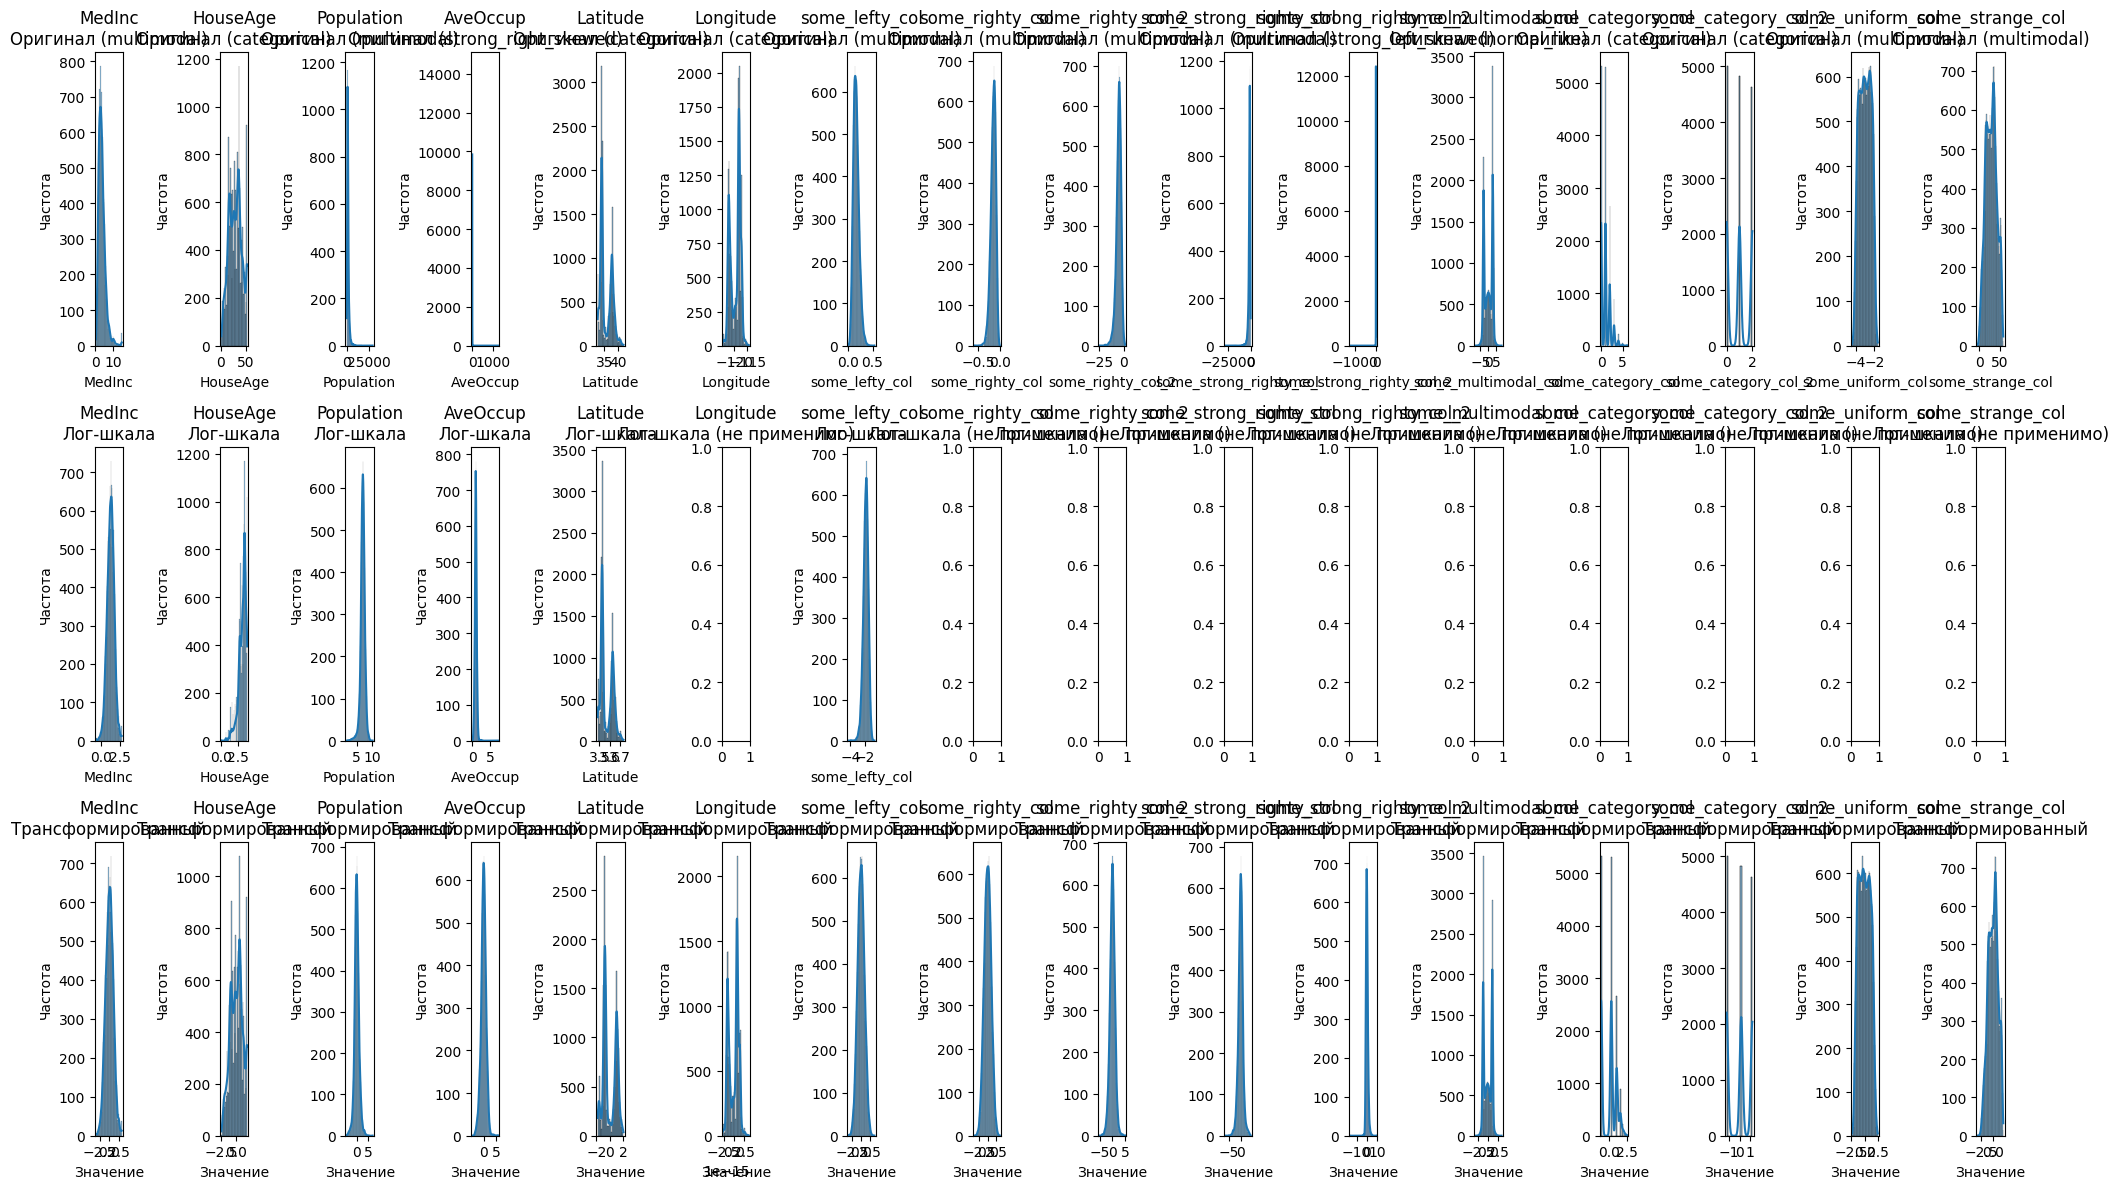


Определенные типы распределений:
MedInc: multimodal
HouseAge: categorical
Population: multimodal
AveOccup: strong_right_skewed
Latitude: categorical
Longitude: categorical
some_lefty_col: multimodal
some_righty_col: multimodal
some_righty_col_2: multimodal
some_strong_righty_col: multimodal
some_strong_righty_col_2: strong_left_skewed
some_multimodal_col: normal_like
some_category_col: categorical
some_category_col_2: categorical
some_uniform_col: multimodal
some_strange_col: multimodal


In [6]:
train_df = df.sample(frac=0.7, random_state=42)
test_df = df.drop(train_df.index)
    
    # Обучение и трансформация
normalizer = normalizer()
normalizer.fit(train_df)
train_transformed = normalizer.transform(train_df)
test_transformed = normalizer.transform(test_df)

# Визуализация результатов
print("Сравнение распределений до и после трансформации:")
normalizer.plot_comparison(train_df, train_transformed, figsize=(20, 12))

# Вывод информации о типах распределений
print("\nОпределенные типы распределений:")
for col, dist_type in normalizer.distribution_types_.items():
    print(f"{col}: {dist_type}")

In [7]:
def hartigan_dip_test(data):
    """
    Тест Хартлигана на мультимодальность
    
    Parameters:
    data : array-like
        Входные данные
        
    Returns:
    dip_stat : float
        Статистика теста
    p_value : float
        p-value (приблизительное)
    """
    dip_stat = stats.dip(data)[0]
    
    # Для получения p-value обычно используют bootstrap
    # Здесь упрощенная версия
    n = len(data)
    if dip_stat > 0.05:  # Эмпирические пороги
        p_value = 0.01   # Условное значение
    else:
        p_value = 0.5
        
    return dip_stat, p_value

# Пример использования
import numpy as np

# Унимодальное распределение
unimodal_data = np.random.normal(0, 1, 1000)
dip_stat_uni, p_uni = hartigan_dip_test(unimodal_data)

# Бимодальное распределение
bimodal_data = np.concatenate([
    np.random.normal(-2, 1, 500),
    np.random.normal(2, 1, 500)
])
dip_stat_bi, p_bi = hartigan_dip_test(bimodal_data)

print(f"Унимодальное: dip={dip_stat_uni:.4f}, p={p_uni:.4f}")
print(f"Бимодальное: dip={dip_stat_bi:.4f}, p={p_bi:.4f}")

AttributeError: module 'scipy.stats' has no attribute 'dip'